In [ ]:
!pip install mediapipe
!pip install tqdm

import cv2
import math
import time

import numpy as np
import mediapipe as mp

from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [ ]:
!pip install ipdb
import ipdb
import argparse

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [ ]:
def pdzl(left, right):
  if abs(left - right) < 1:
    return True
  return False

def getLinearEquation(p1x, p1y, p2x, p2y):
    sign = 1
    a = p2y - p1y
    if a < 0:
        sign = -1
        a = sign * a
    b = sign * (p1x - p2x)
    c = sign * (p1y * p2x - p1x * p2y)
    k = -(a / b)
    b = -(c / b)
    return k, b

def compute_perspective_transform(corner_points, height, width, image):
	corner_points_array = np.float32(corner_points)
	tl, tr, bl, br = corner_points_array
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	img_params = np.float32([[0, 0], [maxWidth, 0], [0, maxHeight], [maxWidth, maxHeight]])
	matrix = cv2.getPerspectiveTransform(corner_points_array, img_params) 
	img_transformed = cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))
	return matrix, img_transformed
  
def compute_point_perspective_transformation(matrix,list_downoids):
	list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
	transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
	transformed_points_list = list()
	for i in range(0, transformed_points.shape[0]):
		transformed_points_list.append([transformed_points[i][0][0], transformed_points[i][0][1]])
	return transformed_points_list

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 从右往左跳
input_path = "/content/drive/MyDrive/xmu/体测/vedio/跳远/ty2.mp4"
output_name = "ty_test.mp4"
output_fps = 30.0

cap = cv2.VideoCapture(input_path)
out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*"MP4V"),
                      output_fps, (int(cap.get(3)), int(cap.get(4))))

image_width = int(cap.get(3))
image_hight = int(cap.get(4))
frame_sum = cap.get(7)
frame_middle = cap.get(7) / 2
frame_count = 0
frame_slide = 0  # 设置时长阈值
k = None
ak = None
maximum_left_begin_ak = 0.0
maximum_left_end_ak = 0.0
maximum_right_begin_ak = 0.0
maximum_right_end_ak = 0.0
angle_begin = 60  # 开始阈值
angle_end = 60  # 结束阈值
x_left_heel_begin = None
x_left_heel_end = None
maximum_end_time = None

x_begin = 0
y_begin = 0
x_end = 0
y_end = 0
x_flag = 0
pTime = 0
pbar = tqdm(total=frame_sum, desc="处理进度")

# ******************************
xx = []
yy = []
# *****************************
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, image = cap.read()  # ipdb.set_trace()
        if not success:
            # If loading a video, use 'break' instead of 'continue'.
            break

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        # find the point
        if results.pose_landmarks is None:
            pass
        else:
            x_left_hip = results.pose_landmarks.landmark[23].x * image_width
            y_left_hip = results.pose_landmarks.landmark[23].y * image_hight
            x_left_knee = results.pose_landmarks.landmark[25].x * image_width
            y_left_knee = results.pose_landmarks.landmark[25].y * image_hight
            x_left_ankle = results.pose_landmarks.landmark[27].x * image_width
            y_left_ankle = results.pose_landmarks.landmark[27].y * image_hight
            x_left_heel = results.pose_landmarks.landmark[29].x * image_width
            y_left_heel = results.pose_landmarks.landmark[29].y * image_hight
            k_left = (y_left_knee - y_left_ankle) / (x_left_knee - x_left_ankle)
            ak_left = abs(math.degrees(math.atan(k_left)))  # 算角度

            if x_flag == 0:
                x_left_heel_flag = x_left_heel - 80
                x_flag = 1

            x_right_hip = results.pose_landmarks.landmark[24].x * image_width
            y_right_hip = results.pose_landmarks.landmark[24].y * image_hight
            x_right_knee = results.pose_landmarks.landmark[26].x * image_width
            y_right_knee = results.pose_landmarks.landmark[26].y * image_hight
            x_right_ankle = results.pose_landmarks.landmark[28].x * image_width
            y_right_ankle = results.pose_landmarks.landmark[28].y * image_hight
            x_right_heel = results.pose_landmarks.landmark[30].x * image_width
            y_right_heel = results.pose_landmarks.landmark[30].y * image_hight
            k_right = (y_right_knee - y_right_ankle) / (x_right_knee - x_right_ankle)
            ak_right = abs(math.degrees(math.atan(k_right)))

        if ak_left and ak_right:
            gz1 = False  # gz1：左右脚跟相隔1单位以内
            if pdzl(x_left_knee, x_right_knee) and pdzl(x_left_ankle, x_right_ankle):
                gz1 = True

            if ak_left > angle_begin and ak_right > angle_begin and x_left_heel > x_left_heel_flag and gz1:
                if ak_left > maximum_left_begin_ak and ak_right > maximum_right_begin_ak:
                    maximum_begin_time = frame_count
                    cv2.imwrite("maximum_begin.png", image)
                    maximum_left_begin_ak = ak_left
                    maximum_right_begin_ak = ak_right
                    x_left_heel_begin = x_left_heel
                    y_left_heel_begin = y_left_heel
                    x_right_heel_begin = x_right_heel
                    y_right_heel_begin = y_right_heel
                    #print("start更新成功！！！！")

            if ak_left > angle_end and ak_right > angle_end and x_left_heel < x_left_heel_flag and gz1:
                if ak_left > maximum_left_end_ak and ak_right > maximum_right_end_ak:
                    maximum_end_time = frame_count
                    cv2.imwrite("maximum_end.png", image)
                    maximum_left_end_ak = ak_left
                    maximum_right_end_ak = ak_right
                    x_left_heel_end = x_left_heel
                    y_left_heel_end = y_left_heel
                    x_right_heel_end = x_right_heel
                    y_right_heel_end = y_right_heel
                    #print("end更新成功！！！！")

        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

# begin
        if x_left_heel_begin and x_left_heel_end:
          x_begin = int(x_left_heel_begin)
          y_begin = int(y_left_heel_begin)
          x_end = int(x_left_heel_end)
          y_end = int(y_left_heel_end)
          qd = (x_begin, y_begin)
          zd = (x_end, y_end)
          zx = (int(x_right_heel_end - 50), int(image_hight - 50))
          yx = (int(x_right_heel_begin + 50), int(image_hight - 50))
          zs = (int(x_left_heel_end - 50), int(y_left_heel_end - 50))
          ys = (int(x_left_heel_begin + 50), int(y_left_heel_begin - 50))
          cv2.rectangle(image, zs, yx, (0, 0, 255), 2)
          cv2.circle(image, qd, 1, (255, 0, 0), 20)
          cv2.circle(image, zd, 1, (255, 0, 0), 20)
        x = int(x_left_heel)
        y = int(y_left_heel)
        xx.append(x)
        yy.append(y)
        
        if frame_count > 1:
          for i in range(frame_count):
            cv2.line(image, (xx[i], yy[i]), (xx[i - 1], yy[i - 1]), (0, 255, 0), 3)
        #cv2.circle(image, (x, y), 10, (255, 0, 0), 5)
        if frame_count == maximum_end_time:
          cv2.imwrite("demo.png", image)
          #print("画完啦！")
# end



        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        cv2.putText(image, f'fps = {str(int(fps))}', (70, 100), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
        out.write(image)
        frame_count += 1
        pbar.update(1)
        if cv2.waitKey(5) & 0xFF == 27:
            break

print("end!")
print(f"开始时左脚后跟坐标：x:{x_left_heel_begin}, y:{y_left_heel_begin}")
print(f"开始时右脚后跟坐标：x:{x_right_heel_begin}, y:{y_right_heel_begin}")
print(f"结束时左脚后跟坐标：x:{x_left_heel_end}, y:{y_left_heel_end}")
print(f"结束时右脚后跟坐标：x:{x_right_heel_end}, y:{y_right_heel_end}")
print("开始时帧数：", maximum_begin_time)
print("结束时帧数：", maximum_end_time)

cap.release()
out.release()
pbar.close()

处理进度: 100%|██████████| 81/81.0 [00:03<00:00, 22.25it/s]


end!
开始时左脚后跟坐标：x:603.4372806549072, y:386.0686683654785
开始时右脚后跟坐标：x:603.8643822669983, y:383.0141544342041
结束时左脚后跟坐标：x:341.18275785446167, y:380.27698516845703
结束时右脚后跟坐标：x:340.22505736351013, y:377.9432773590088
开始时帧数： 2
结束时帧数： 79


In [ ]:
# 从右往左跳
input_path = "/content/drive/MyDrive/xmu/体测/vedio/跳远/ty5.mp4"
output_name = "ty_test.mp4"
output_fps = 30.0

cap = cv2.VideoCapture(input_path)
out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*"MP4V"),
                      output_fps, (int(cap.get(3)), int(cap.get(4))))

image_width = int(cap.get(3))
image_hight = int(cap.get(4))
frame_sum = cap.get(7)
frame_middle = cap.get(7) / 2
frame_count = 0
frame_slide = 0  # 设置时长阈值
k = None
ak = None
maximum_left_begin_ak = 0.0
maximum_left_end_ak = 0.0
maximum_right_begin_ak = 0.0
maximum_right_end_ak = 0.0
angle_begin = 60  # 开始阈值
angle_end = 60  # 结束阈值
x_left_heel_begin = None
x_left_heel_end = None
maximum_end_time = None

x_begin = 0
y_begin = 0
x_end = 0
y_end = 0
x_flag = 0
pTime = 0
dist_pdkd = 120
distance_transformed = 0
frame_count_t = None
pbar = tqdm(total=frame_sum, desc="处理进度")

# ******************************
xx = []
yy = []
# *****************************
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, image = cap.read()  # ipdb.set_trace()
        if not success:
            # If loading a video, use 'break' instead of 'continue'.
            break

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        # find the point
        if results.pose_landmarks is None:
            pass
        else:
            x_left_hip = results.pose_landmarks.landmark[23].x * image_width
            y_left_hip = results.pose_landmarks.landmark[23].y * image_hight
            x_left_knee = results.pose_landmarks.landmark[25].x * image_width
            y_left_knee = results.pose_landmarks.landmark[25].y * image_hight
            x_left_ankle = results.pose_landmarks.landmark[27].x * image_width
            y_left_ankle = results.pose_landmarks.landmark[27].y * image_hight
            x_left_heel = results.pose_landmarks.landmark[29].x * image_width
            y_left_heel = results.pose_landmarks.landmark[29].y * image_hight
            k_left = (y_left_knee - y_left_ankle) / (x_left_knee - x_left_ankle)
            ak_left = abs(math.degrees(math.atan(k_left)))  # 算角度

            if x_flag == 0:
                x_left_heel_flag = x_left_heel - 80
                x_flag = 1

            x_right_hip = results.pose_landmarks.landmark[24].x * image_width
            y_right_hip = results.pose_landmarks.landmark[24].y * image_hight
            x_right_knee = results.pose_landmarks.landmark[26].x * image_width
            y_right_knee = results.pose_landmarks.landmark[26].y * image_hight
            x_right_ankle = results.pose_landmarks.landmark[28].x * image_width
            y_right_ankle = results.pose_landmarks.landmark[28].y * image_hight
            x_right_heel = results.pose_landmarks.landmark[30].x * image_width
            y_right_heel = results.pose_landmarks.landmark[30].y * image_hight
            k_right = (y_right_knee - y_right_ankle) / (x_right_knee - x_right_ankle)
            ak_right = abs(math.degrees(math.atan(k_right)))

        if ak_left and ak_right:
            gz1 = False  # gz1：左右脚跟相隔1单位以内
            if pdzl(x_left_knee, x_right_knee) and pdzl(x_left_ankle, x_right_ankle):
                gz1 = True

            if ak_left > angle_begin and ak_right > angle_begin and x_left_heel > x_left_heel_flag and gz1:
                if ak_left > maximum_left_begin_ak and ak_right > maximum_right_begin_ak:
                    maximum_begin_time = frame_count
                    cv2.imwrite("maximum_begin.png", image)
                    maximum_left_begin_ak = ak_left
                    maximum_right_begin_ak = ak_right
                    x_left_heel_begin = x_left_heel
                    y_left_heel_begin = y_left_heel
                    x_right_heel_begin = x_right_heel
                    y_right_heel_begin = y_right_heel
                    #print("start更新成功！！！！")

            if ak_left > angle_end and ak_right > angle_end and x_left_heel < x_left_heel_flag and gz1:
                if ak_left > maximum_left_end_ak and ak_right > maximum_right_end_ak:
                    maximum_end_time = frame_count
                    cv2.imwrite("maximum_end.png", image)
                    maximum_left_end_ak = ak_left
                    maximum_right_end_ak = ak_right
                    x_left_heel_end = x_left_heel
                    y_left_heel_end = y_left_heel
                    x_right_heel_end = x_right_heel
                    y_right_heel_end = y_right_heel
                    #print("end更新成功！！！！")

        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# 轨迹
        x = int(x_left_heel)
        y = int(y_left_heel)
        xx.append(x)
        yy.append(y)
        if frame_count > 1:
          for i in range(frame_count):
            cv2.line(image, (xx[i], yy[i]), (xx[i - 1], yy[i - 1]), (0, 255, 0), 2)

# begin
        if x_left_heel_begin and x_left_heel_end:
          x_begin = int(x_left_heel_begin)
          y_begin = int(y_left_heel_begin)
          x_end = int(x_left_heel_end)
          y_end = int(y_left_heel_end)
          
          qd = (x_begin, y_begin)
          zd = (x_end, y_end)
          #cv2.circle(image, qd, 1, (255, 0, 0), 10)  # 画起点
          cv2.circle(image, zd, 1, (255, 0, 0), 10)
          
          zx = (int(x_right_heel_end - 175), int(y_right_heel_end + 50))
          yx = (int(x_right_heel_begin + 155), int(y_right_heel_begin + 50))
          zs = (int(x_left_heel_end - 35), int(y_left_heel_end - 50))
          ys = (int(x_left_heel_begin + 20), int(y_left_heel_begin - 50))
          corner_points = [zx, yx, zs, ys]
        
          qdd_x = int(x_right_heel_begin - 30)
          qdd_y = int(kkk * x + bbb)
          qdd = (qdd_x, qdd_y)

          zdd_x = int(x_right_heel_begin - 140)
          zdd_y = int(kkk * x + bbb)
          zdd = (zdd_x, zdd_y)

          matrix, img_transformed = compute_perspective_transform(corner_points, image.shape[1], image.shape[0], image)

          list_downoids = [[x_begin, y_begin], [x_end, y_end], [qdd_x, qdd_y], [zdd_x, zdd_y]]
          transformed_points_list = compute_point_perspective_transformation(matrix, list_downoids)
          x_qdd_transformed = transformed_points_list[2][0]
          y_qdd_transformed = transformed_points_list[2][1]
          x_zdd_transformed = transformed_points_list[3][0]
          y_zdd_transformed = transformed_points_list[3][1]
          x_start_transformed = transformed_points_list[2][0]
          y_start_transformed = transformed_points_list[2][1]
          x_end_transformed = transformed_points_list[1][0]
          y_end_transformed = transformed_points_list[1][1]

          dist_raw = np.sqrt(((x_end - qdd_x) ** 2) + ((y_end - qdd_y) ** 2))
          dist_xy = np.sqrt(((x_end_transformed - x_start_transformed) ** 2) + ((y_end_transformed - y_start_transformed) ** 2))
          dist_pd = np.sqrt(((x_zdd_transformed - x_qdd_transformed) ** 2) + ((y_zdd_transformed - y_qdd_transformed) ** 2))
          distance_raw = dist_raw / dist_pd * dist_pdkd

          distance_transformed = dist_xy / dist_pd * dist_pdkd



        if frame_count == maximum_end_time:
          cv2.putText(image, f'distance = {str(int(distance_transformed))} cm', (70, 100), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 255), 2)
          cv2.imwrite("demo.png", image)
          #print("画完啦！")
# end





# 打印文本
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        cv2.putText(image, f'fps = {str(int(fps))}', (70, 50), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 255), 2)
        cv2.putText(image, f'distance = {str(int(distance_transformed))} cm', (70, 100), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 255), 2)

# over
        out.write(image)
        frame_count += 1
        pbar.update(1)
        if cv2.waitKey(5) & 0xFF == 27:
            break

print("end!")
print(f"开始时左脚后跟坐标：x:{x_left_heel_begin}, y:{y_left_heel_begin}")
print(f"开始时右脚后跟坐标：x:{x_right_heel_begin}, y:{y_right_heel_begin}")
print(f"结束时左脚后跟坐标：x:{x_left_heel_end}, y:{y_left_heel_end}")
print(f"结束时右脚后跟坐标：x:{x_right_heel_end}, y:{y_right_heel_end}")
print("开始时帧数：", maximum_begin_time)
print("结束时帧数：", maximum_end_time)

cap.release()
out.release()
pbar.close()

处理进度: 100%|██████████| 87/87.0 [00:03<00:00, 22.19it/s]

end!
开始时左脚后跟坐标：x:606.4446964263916, y:389.07073974609375
开始时右脚后跟坐标：x:606.3027544021606, y:385.80410957336426
结束时左脚后跟坐标：x:443.87832260131836, y:382.11310386657715
结束时右脚后跟坐标：x:444.4647135734558, y:380.52005767822266
开始时帧数： 11
结束时帧数： 74


In [ ]:
kkk, bbb = getLinearEquation(x_begin, y_begin, x_end, y_end)

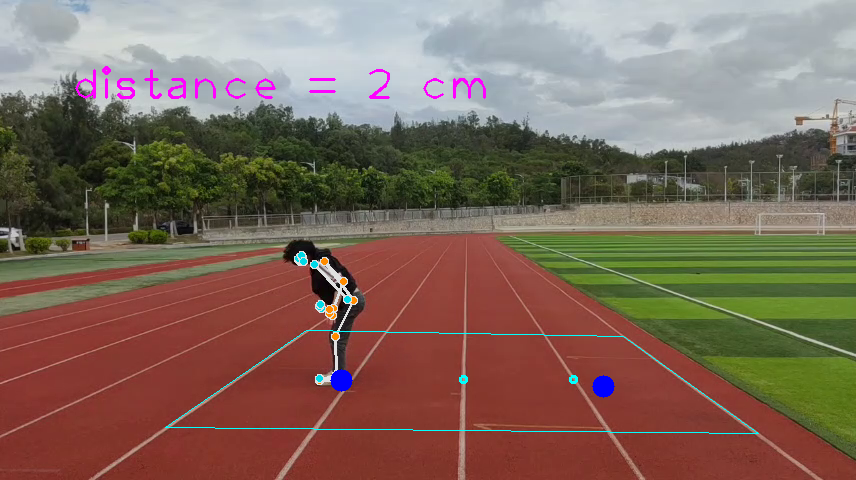

In [ ]:
demo = cv2.imread('/content/demo.png')
zx = (int(x_right_heel_end - 175), int(y_right_heel_end + 50))
yx = (int(x_right_heel_begin + 155), int(y_right_heel_begin + 50))
zs = (int(x_left_heel_end - 35), int(y_left_heel_end - 50))
ys = (int(x_left_heel_begin + 20), int(y_left_heel_begin - 50))
pts = np.array([zx, yx, ys, zs], np.int32)  # 数据类型必须为 int32
pts = pts.reshape((-1, 1, 2))
cv2.polylines(demo, [pts], isClosed=True, color=(255, 255, 0), thickness=1)

qdd_x = int(x_right_heel_begin - 30)
qdd_y = int(kkk * x + bbb)
qdd = (qdd_x, qdd_y)
cv2.circle(demo, qdd, 3, (255, 255, 0), 2)

zdd_x = int(x_right_heel_begin - 140)
zdd_y = int(kkk * x + bbb)
zdd = (zdd_x, zdd_y)
cv2.circle(demo, zdd, 3, (255, 255, 0), 2)


cv2_imshow(demo)

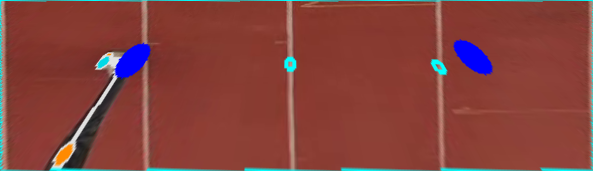

In [ ]:
corner_points = [zx, yx, zs, ys]
def compute_perspective_transform(corner_points, height, width, image):
	corner_points_array = np.float32(corner_points)
	tl, tr, bl, br = corner_points_array
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	img_params = np.float32([[0, 0], [maxWidth, 0], [0, maxHeight], [maxWidth, maxHeight]])
	matrix = cv2.getPerspectiveTransform(corner_points_array, img_params) 
	img_transformed = cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))
	return matrix, img_transformed

matrix, img_transformed = compute_perspective_transform(corner_points, demo.shape[1], demo.shape[0], demo)
cv2_imshow(img_transformed)

In [ ]:
def compute_point_perspective_transformation(matrix,list_downoids):
	list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
	transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
	transformed_points_list = list()
	for i in range(0, transformed_points.shape[0]):
		transformed_points_list.append([transformed_points[i][0][0], transformed_points[i][0][1]])
	return transformed_points_list

	
list_downoids = [[x_begin, y_begin], [x_end, y_end], [qdd_x, qdd_y], [zdd_x, zdd_y]]
transformed_points_list = compute_point_perspective_transformation(matrix, list_downoids)
x_qdd_transformed = transformed_points_list[2][0]
y_qdd_transformed = transformed_points_list[2][1]
x_zdd_transformed = transformed_points_list[3][0]
y_zdd_transformed = transformed_points_list[3][1]
x_start_transformed = transformed_points_list[2][0]
y_start_transformed = transformed_points_list[2][1]
x_end_transformed = transformed_points_list[1][0]
y_end_transformed = transformed_points_list[1][1]

dist_pdkd = 1.2
dist_raw = np.sqrt(((x_end - qdd_x) ** 2) + ((y_end - qdd_y) ** 2))
dist_xy = np.sqrt(((x_end_transformed - x_start_transformed) ** 2) + ((y_end_transformed - y_start_transformed) ** 2))
dist_pd = np.sqrt(((x_zdd_transformed - x_qdd_transformed) ** 2) + ((y_zdd_transformed - y_qdd_transformed) ** 2))
distance_raw = dist_raw / dist_pd * dist_pdkd
distance_transformed = dist_xy / dist_pd * dist_pdkd

In [ ]:
distance_transformed

2.4675743314738114

In [ ]:
dist_yt = np.sqrt(((x_end - qdd_x) ** 2) + ((y_end - qdd_y) ** 2))
dist_qdd = np.sqrt(((qdd_x - zdd_x) ** 2) + ((qdd_y - zdd_y) ** 2))
dist_xt = np.sqrt(((transformed_points_list[2][0] - transformed_points_list[1][0]) ** 2) + ((transformed_points_list[2][1] - transformed_points_list[1][1]) ** 2))
dist_zdd = np.sqrt(((transformed_points_list[2][0] - transformed_points_list[3][0]) ** 2) + ((transformed_points_list[2][1] - transformed_points_list[3][1]) ** 2))
distance_1 = dist_yt / dist_qdd * 1.2
distance_2 = dist_xt / dist_zdd * 1.2
print(dist_yt)
print(dist_xt)
print(dist_qdd)
print(dist_zdd)
print(distance_1)
print(distance_2)

232.0021551624036
305.55769705407135
110.0
148.59501162256157
2.5309326017716756
2.4675743314738114


In [ ]:
list_downoids

[[599, 378], [363, 371]]

In [ ]:
transformed_points_list

[[454.30164, 55.05995], [144.50188, 59.795753]]

In [ ]:
def compute_perspective_transform(corner_points, image):
	corner_points_array = np.float32(corner_points)
	img_params = np.float32([[0,0], [image.shape[1],0], [image.shape[1],image.shape[0]]])
	matrix = cv2.getAffineTransform(corner_points_array,img_params) 
	img_transformed = cv2.warpAffine(image,matrix,(image.shape[1],image.shape[0]))
	return matrix,img_transformed

matrix, img_transformed = compute_perspective_transform(corner_points, image_end)

In [ ]:
zx = (int(x_right_heel_begin - 50), int(image_hight - 50))
yx = (int(image_width-20), int(image_hight - 50))
zs = (int(x_left_heel_begin - 50), int(y_left_heel_begin - 50))
ys = (int(image_width - 20), int(y_left_heel_end - 50))
cv2.circle(image, zx, 10, (255, 0, 0), 5)
cv2.circle(image, yx, 10, (255, 0, 0), 5)
cv2.circle(image, zs, 10, (255, 0, 0), 5)
cv2.circle(image, ys, 10, (255, 0, 0), 5)
cv2.circle(image, (int(x_left_heel_end), int(y_left_heel_end)), 10, (255, 0, 0), 5)
#cv2.putText(image, 'o', (int(x_left_ankle), int(y_left_ankle)), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
#cv2.putText(image, f'fps = {str(int(fps))}', (70, 100), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
#cv2.putText(image, f"ak_left = {str(int(x_left_heel))}", (100, 100), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
#cv2.putText(image, f"ak_right = {str(int(ak_right))}", (100, 150), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
#cv2.putText(image, f"akk_left = {str(int(akk_left))}", (100, 200), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
#cv2.putText(image, f"akk_right = {str(int(akk_right))}", (100, 250), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
#cv2.putText(image, f"frame_count = {str(int(frame_count))}", (30, 30), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
if frame_count == 101:
corner_points = [zx, yx, ys, zs]
def compute_perspective_transform(corner_points, image):
  corner_points_array = np.float32(corner_points)
  tl, tr, br, bl = corner_points_array
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  img_params = np.float32([[0, 0], [maxWidth-1, 0], [maxWidth-1, maxHeight-1], [0, maxHeight-1]])
  matrix = cv2.getPerspectiveTransform(corner_points_array,img_params) 
  img_transformed = cv2.warpPerspective(image,matrix,(image.shape[1],image.shape[0]))
  return matrix,img_transformed

image_end = cv2.imread('/content/maximum_end.png')
matrix, img_transformed = compute_perspective_transform(corner_points_perspective, image_end)

In [ ]:
img_transformed.shape

(480, 856, 3)

In [ ]:
image_end.shape

(480, 856, 3)

In [ ]:
akk_left_list

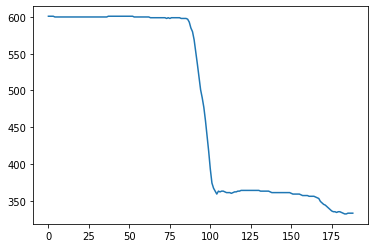

In [ ]:
plt.plot(range(len(xx)), xx)
plt.show()

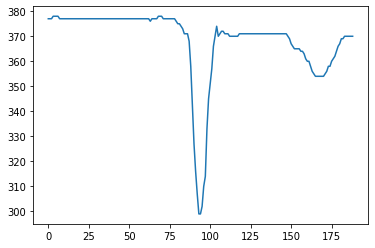

In [ ]:
plt.plot(range(len(yy)), yy)
plt.show()